episode 0
episode 10
episode 20
episode 30
episode 40


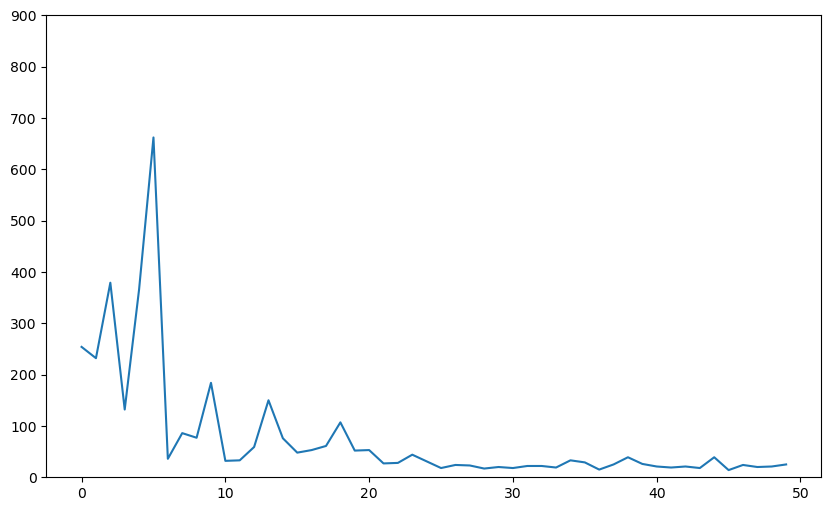

In [11]:
import numpy as np
import matplotlib.pyplot as plt

ROWS = 6
COLS = 9
S = (2, 0)
G = (0, 8)
BLOCKS = [(1, 2), (2, 2), (3, 2), (0, 7), (1, 7), (2, 7), (4, 5)]
ACTIONS = ["left", "up", "right", "down"]


class Maze:

    def __init__(self):
        self.rows = ROWS
        self.cols = COLS
        self.start = S
        self.goal = G
        self.blocks = BLOCKS
        self.state = S
        self.end = False
        # init maze
        self.maze = np.zeros((self.rows, self.cols))
        for b in self.blocks:
            self.maze[b] = -1

    def nxtPosition(self, action):
        r, c = self.state
        if action == "left":
            c -= 1
        elif action == "right":
            c += 1
        elif action == "up":
            r -= 1
        else:
            r += 1

        if (r >= 0 and r <= self.rows - 1) and (c >= 0 and c <= self.cols - 1):
            if (r, c) not in self.blocks:
                self.state = (r, c)
        return self.state

    def giveReward(self):
        if self.state == self.goal:
            self.end = True
            return 1
        else:
            return 0

    def showMaze(self):
        self.maze[self.state] = 1
        for i in range(0, self.rows):
            print('-------------------------------------')
            out = '| '
            for j in range(0, self.cols):
                if self.maze[i, j] == 1:
                    token = '*'
                if self.maze[i, j] == -1:
                    token = 'z'
                if self.maze[i, j] == 0:
                    token = '0'
                out += token + ' | '
            print(out)
        print('-------------------------------------')


class DynaAgentPlus:

    def __init__(self, exp_rate=0.3, lr=0.1, n_steps=5, episodes=1, timeWeight=1e-4):
        self.time = 0  # keep track of the total time
        self.timeWeight = timeWeight
        self.maze = Maze()
        self.state = S
        self.actions = ACTIONS
        self.state_actions = []  # state & action track
        self.exp_rate = exp_rate
        self.lr = lr

        self.steps = n_steps
        self.episodes = episodes  # number of episodes going to play
        self.steps_per_episode = []

        self.Q_values = {}
        # model function
        self.model = {}
        for row in range(ROWS):
            for col in range(COLS):
                self.Q_values[(row, col)] = {}
                for a in self.actions:
                    self.Q_values[(row, col)][a] = 0

    def chooseAction(self):
        # epsilon-greedy
        mx_nxt_reward = -999
        action = ""

        if np.random.uniform(0, 1) <= self.exp_rate:
            action = np.random.choice(self.actions)
        else:
            # greedy action
            current_position = self.state
            # if all actions have same value, then select randomly
            if len(set(self.Q_values[current_position].values())) == 1:
                action = np.random.choice(self.actions)
            else:
                for a in self.actions:
                    nxt_reward = self.Q_values[current_position][a]
                    if nxt_reward >= mx_nxt_reward:
                        action = a
                        mx_nxt_reward = nxt_reward
        return action

    def reset(self):
        self.maze = Maze()
        self.state = S
        self.state_actions = []
        self.time = 0

    def updateModel(self, state, nxtState, action, reward):
        if state not in self.model.keys():
            self.model[state] = {}
        for a in self.actions:
            # the initial model for such actions was that they would
            # lead back to the same state with a reward of 0.
            if a != action:
                self.model[state][a] = (0, state, 1)

        self.model[state][action] = (reward, nxtState, self.time)

    def play(self):
        self.steps_per_episode = []

        for ep in range(self.episodes):
            while not self.maze.end:

                action = self.chooseAction()
                self.state_actions.append((self.state, action))

                nxtState = self.maze.nxtPosition(action)
                reward = self.maze.giveReward()

                # update Q-value
                self.Q_values[self.state][action] += self.lr * (reward + np.max(list(self.Q_values[nxtState].values())) - self.Q_values[self.state][action])

                # update model
                self.updateModel(self.state, nxtState, action, reward)
                self.state = nxtState
                self.time += 1

                # loop n times to randomly update Q-value
                for _ in range(self.steps):
                    # randomly choose an state
                    rand_idx = np.random.choice(range(len(self.model.keys())))
                    _state = list(self.model)[rand_idx]
                    # randomly choose an action
                    rand_idx = np.random.choice(range(len(self.model[_state].keys())))
                    _action = list(self.model[_state])[rand_idx]

                    _reward, _nxtState, _time = self.model[_state][_action]
                    # update _reward
                    _reward += self.timeWeight * np.sqrt(self.time - _time)

                    self.Q_values[_state][_action] += self.lr * (_reward + np.max(list(self.Q_values[_nxtState].values())) - self.Q_values[_state][_action])
            # end of game
            if ep % 10 == 0:
                print("episode", ep)
            self.steps_per_episode.append(len(self.state_actions))
            self.reset()


if __name__ == "__main__":
    N_EPISODES = 50
    dyna = DynaAgentPlus(n_steps=0, episodes=N_EPISODES)
    dyna.play()
    
    steps_episode_0 = dyna.steps_per_episode
    
   
    
    plt.figure(figsize=[10, 6])

    plt.ylim(0, 900)
    plt.plot(range(N_EPISODES), steps_episode_0, label="step=0")
   